# TD2 part 2: Named entity recognition

Dans ce TD, nous allons prendre un datasets où les noms de personnes sont taggés.<br>
Nous allons transformer ces données en tenseurs X, y et attention_mask.<br>
Nous allons créer un modèle RNN pour prédire si un mot est un nom de personne.<br>
Nous allons ensuite créer la loop avec l'optimizer pour apprendre le modèle.<br>
Du modèle appris (prédisant sur les tokens), nous allons postprocess les prédictions pour avoir les prédictions sur les noms.

Un fois que la loop est créée et que le modèle apprend, nous allons changer la structure du modèle:
- Changer learning rate. Comment se comporte le modèle
- Ajouter des couches denses, ReLU, dropout, normalization
- Changer le nombre de layers du RNN, LSTM.

Lorsqu'on a un bon modèle de prédiction pour les noms de personnes, nous allons l'appliquer à notre projet fil rouge.
Utilisez-le tel que. Quelle accuracy ?
Ré-entrainez la (les) dernière(s) couche(s) du modèle sur notre jeu de données. A-t-il gagné en accuracy ?

In [1]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers

## Data

Télécharger le dataset MultiNERD FR [ici](https://github.com/Babelscape/multinerd)<br>
Mettez les données dans le dossier data/raw du projet.


In [2]:
def extract_multinerd_person_words(filename="../src/data/raw/train_fr.tsv"):
    with open(filename) as f:
        tagged_words = [line.strip().split("\t") for line in f]
        
        # Joining words until we meet a dot
        # Word's label is 1 if 'PER' is in its tag
        sentences = []
        sentence_labels = []
    
        this_word = []
        this_labels = []
        for tagged_word in tagged_words:
            if len(tagged_word) < 3:
                # not a tagged word
                continue
            word = tagged_word[1]
            tag = tagged_word[2]
        
            if word == '.':
                sentences.append(" ".join(this_word))
                sentence_labels.append(this_labels)
            
                this_word = []
                this_labels = []
            else:
                this_word.append(word)
                this_labels.append(1 * tag.endswith("PER"))

    return sentences, sentence_labels


In [3]:
examples, labels = extract_multinerd_person_words()

## Tokenizer

En utilisant le tokenizer d'HuggingFace "camembert-base":
- Transformer les phrases en tokens
- Obtenez des vecteur y qui ont le même nombre d'entrées qu'il y a de tokens dans la phrase
- Ayez un tenseur "attention_mask" pour savoir sur quels tokens on cherche à predire le label
- Transformez les tokens en token_ids (avec le tokenizer)
Avec tout cela, vous pouvez former vos tenseurs X, Y et attention_mask

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("camembert-base")

In [5]:
def build_tokens_and_labels_and_attention_mask(tokenizer, sentence, labels):
    words = sentence.split()
    tokens = []
    tokens_label = []
    attention_mask = []
    
    for word, label in zip(words, labels):
        this_tokens = tokenizer.tokenize(word)
        
        tokens += this_tokens
        
        this_labels = [0] * len(this_tokens)
        this_labels[0] = label        
        tokens_label += this_labels
        this_attention_mask = [1] + [0] * (len(this_tokens) - 1)
        attention_mask += this_attention_mask
        
    return tokens, tokens_label, attention_mask

In [6]:
tokens, label, padding_masks = build_tokens_and_labels_and_attention_mask(tokenizer, examples[0], labels[0])

In [7]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[69, 30, 15897, 37, 114, 17140, 156, 891, 8385]

In [8]:
def get_train_dataset(tokenizer, sentences, labels, max_len):
    X = []
    Y = []
    attention_masks = []

    for sentence, label in zip(sentences, labels):
        this_tokens, this_label_ids, this_attention_mask = build_tokens_and_labels_and_attention_mask(tokenizer, sentence, label)

        this_token_ids = tokenizer.convert_tokens_to_ids(this_tokens)

        padding = max_len - len(this_token_ids)
        this_token_ids.extend([0] * padding)
        this_label_ids.extend([0] * padding)
        this_attention_mask.extend([0] * padding)

        X.append(this_token_ids)
        Y.append(this_label_ids)
        attention_masks.append(this_attention_mask)

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    attention_masks = torch.tensor(attention_masks, dtype=torch.long)

    return X, Y, attention_masks

In [9]:
max_len = max([len(tokenizer.encode(sentence)) for sentence in examples])
X, Y, attention_masks = get_train_dataset(tokenizer, examples, labels, max_len)

In [10]:
print(X.shape), print(Y.shape), print(attention_masks.shape)

torch.Size([140436, 350])
torch.Size([140436, 350])
torch.Size([140436, 350])


(None, None, None)

## Model

Contruisez un modèle RNN comme dans la partie 1. Pour l'instant, il prendra comme arguments:
- Vocab size: le nombre de différents tokens du tokenizer (52 000 pour camembert-base)
- Embedding dim: la dimension de l'embedding des tokens (par défaut 50)
- hidden_dim: la dimension de l'état récurrent de votre RNN (par défaut 20)
- tagset_size: la nombre de classes possibles pour les prédictions (ici 2)

Dans le forward, votre modèle enchaînera les couches suivantes:
- Un embedding
- Un RNN
- Un ReLU
- Une couche linéaire
- Un softmax pour que la somme des prédictions pour une entrée soit égale à 1 (la prédiction pour un élément et sa probabilité d'être dans chaque classe)

In [11]:
class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=50, hidden_dim=20, tagset_size=2):
        super(RNNModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        rnn_out = torch.nn.functional.relu(rnn_out)
        out = self.fc(rnn_out)
        return torch.nn.functional.softmax(out, dim=1)

In [12]:
vocab_size = 52000
embedding_dim = 50
hidden_dim = 20
tagset_size = 2

model = RNNModel(vocab_size, embedding_dim, hidden_dim, tagset_size)
model

RNNModel(
  (embedding): Embedding(52000, 50)
  (rnn): RNN(50, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=2, bias=True)
)

## Optimizer

Je fournis ici une fonction prenant un modèle, des tenseurs X, y, attention_mask.
Pour chaque batch:
- La loop utilise le modèle pour prédire sur x_batch
- Avec attention_mask, elle identifie sur quels tokens les prédictions compte
- Elle regarde la cross entropy entre y\[attention_ids\] et yhat\[attention_ids\]
- Elle output un dictionnaire avec le model et la loss au fur et à mesure des itérations

Entraînez le modèle avec vos données. <br>
Plottez la loss history.<br>
Itérez sur le modèle pour l'améliorer:
- Changer learning rate. Comment se comporte le modèle
- Ajouter des couches denses, ReLU, dropout, normalization
- Changer le nombre de layers du RNN, LSTM.



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Entraînement sur: {device}")

Entraînement sur: cuda


In [14]:
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

def train_model(model, X, y, attention_masks, split_ratio=0.8, n_epochs=100, lr=0.05, batch_size=128):
    # Splitting the dataset into training and validation sets
    dataset_size = len(X)
    train_size = int(split_ratio * dataset_size)
    valid_size = dataset_size - train_size
    dataset = TensorDataset(X, y, attention_masks)
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Tracking metrics
    epoch_train_loss_history = []
    epoch_valid_loss_history = []
    epoch_train_accuracy_history = []
    epoch_valid_accuracy_history = []

    for epoch in range(n_epochs):
        # Training
        model.train()
        total_train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0

        for x_batch, y_batch, mask in train_loader:
            optimizer.zero_grad()

            ids = mask.reshape(-1)
            yhat = model(x_batch).reshape((-1, 2))[ids]
            this_y = y_batch.reshape(-1)[ids]

            loss = loss_function(yhat, this_y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(yhat.data, 1)
            total_train_predictions += this_y.size(0)
            correct_train_predictions += (predicted == this_y).sum().item()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = (correct_train_predictions / total_train_predictions) * 100
        epoch_train_loss_history.append(train_loss)
        epoch_train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss = 0
        correct_valid_predictions = 0
        total_valid_predictions = 0

        with torch.no_grad():
            for x_batch, y_batch, mask in valid_loader:
                ids = mask.reshape(-1)
                yhat = model(x_batch).reshape((-1, 2))[ids]
                this_y = y_batch.reshape(-1)[ids]

                loss = loss_function(yhat, this_y)
                total_valid_loss += loss.item()
                _, predicted = torch.max(yhat.data, 1)
                total_valid_predictions += this_y.size(0)
                correct_valid_predictions += (predicted == this_y).sum().item()

        valid_loss = total_valid_loss / len(valid_loader)
        valid_accuracy = (correct_valid_predictions / total_valid_predictions) * 100
        epoch_valid_loss_history.append(valid_loss)
        epoch_valid_accuracy_history.append(valid_accuracy)

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

    return {
        "model": model,
        "train_loss_history": epoch_train_loss_history,
        "valid_loss_history": epoch_valid_loss_history,
        "train_accuracy_history": epoch_train_accuracy_history,
        "valid_accuracy_history": epoch_valid_accuracy_history
    }


In [15]:
X = X.to(device)
Y = Y.to(device)
attention_masks = attention_masks.to(device)

model = model.to(device)

In [16]:
res = train_model(model, X, Y, attention_masks, n_epochs=50, lr=0.005, batch_size=128)

Epoch 0 - Train Loss: 0.3919, Train Accuracy: 94.43%, Valid Loss: 0.3516, Valid Accuracy: 93.27%
Epoch 1 - Train Loss: 0.3646, Train Accuracy: 91.71%, Valid Loss: 0.3514, Valid Accuracy: 93.22%
Epoch 2 - Train Loss: 0.3637, Train Accuracy: 92.03%, Valid Loss: 0.3514, Valid Accuracy: 92.90%
Epoch 3 - Train Loss: 0.3561, Train Accuracy: 93.09%, Valid Loss: 0.3517, Valid Accuracy: 93.59%
Epoch 4 - Train Loss: 0.3583, Train Accuracy: 92.64%, Valid Loss: 0.3485, Valid Accuracy: 93.57%
Epoch 5 - Train Loss: 0.3581, Train Accuracy: 92.81%, Valid Loss: 0.3497, Valid Accuracy: 93.50%
Epoch 6 - Train Loss: 0.3542, Train Accuracy: 93.15%, Valid Loss: 0.3506, Valid Accuracy: 93.23%
Epoch 7 - Train Loss: 0.3547, Train Accuracy: 93.80%, Valid Loss: 0.3523, Valid Accuracy: 95.51%
Epoch 8 - Train Loss: 0.3640, Train Accuracy: 94.34%, Valid Loss: 0.3566, Valid Accuracy: 95.81%
Epoch 9 - Train Loss: 0.3558, Train Accuracy: 94.70%, Valid Loss: 0.3510, Valid Accuracy: 95.20%
Epoch 10 - Train Loss: 0.3555,

In [17]:
def plot_training_results(results):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss_history"], label='Train Loss')
    plt.plot(results["valid_loss_history"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results["train_accuracy_history"], label='Train Accuracy')
    plt.plot(results["valid_accuracy_history"], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

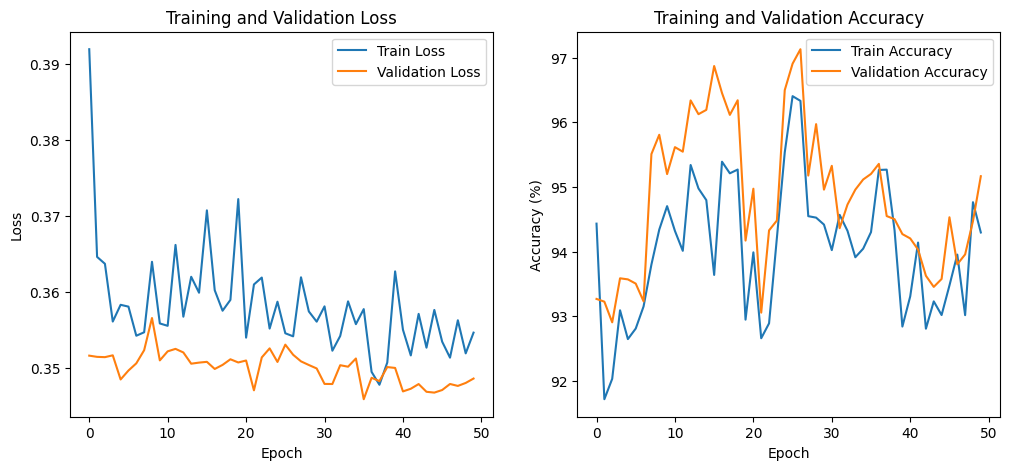

In [18]:
plot_training_results(res)

In [19]:
class LSTMModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=50, hidden_dim=20, tagset_size=2):
        super(RNNModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        rnn_out = torch.nn.functional.relu(rnn_out)
        out = self.fc(rnn_out)
        return torch.nn.functional.softmax(out, dim=1)

In [20]:
vocab_size = 52000
embedding_dim = 50
hidden_dim = 20
tagset_size = 2

model_2 = RNNModel(vocab_size, embedding_dim, hidden_dim, tagset_size)

model_2 = model_2.to(device)

model_2

RNNModel(
  (embedding): Embedding(52000, 50)
  (rnn): RNN(50, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=2, bias=True)
)

In [21]:
res_2 = train_model(model_2, X, Y, attention_masks, n_epochs=50, lr=0.05, batch_size=128)

Epoch 0 - Train Loss: 0.3787, Train Accuracy: 94.42%, Valid Loss: 0.3678, Valid Accuracy: 94.33%
Epoch 1 - Train Loss: 0.3667, Train Accuracy: 95.61%, Valid Loss: 0.3709, Valid Accuracy: 93.78%
Epoch 2 - Train Loss: 0.3752, Train Accuracy: 94.08%, Valid Loss: 0.3812, Valid Accuracy: 94.37%
Epoch 3 - Train Loss: 0.3682, Train Accuracy: 95.08%, Valid Loss: 0.3764, Valid Accuracy: 94.56%
Epoch 4 - Train Loss: 0.3815, Train Accuracy: 94.39%, Valid Loss: 0.3870, Valid Accuracy: 94.90%
Epoch 5 - Train Loss: 0.3801, Train Accuracy: 94.92%, Valid Loss: 0.3826, Valid Accuracy: 95.10%
Epoch 6 - Train Loss: 0.3744, Train Accuracy: 95.44%, Valid Loss: 0.3758, Valid Accuracy: 95.02%
Epoch 7 - Train Loss: 0.3722, Train Accuracy: 95.01%, Valid Loss: 0.3763, Valid Accuracy: 94.98%
Epoch 8 - Train Loss: 0.3775, Train Accuracy: 94.27%, Valid Loss: 0.3767, Valid Accuracy: 93.73%
Epoch 9 - Train Loss: 0.3694, Train Accuracy: 94.36%, Valid Loss: 0.4018, Valid Accuracy: 93.55%
Epoch 10 - Train Loss: 0.3761,

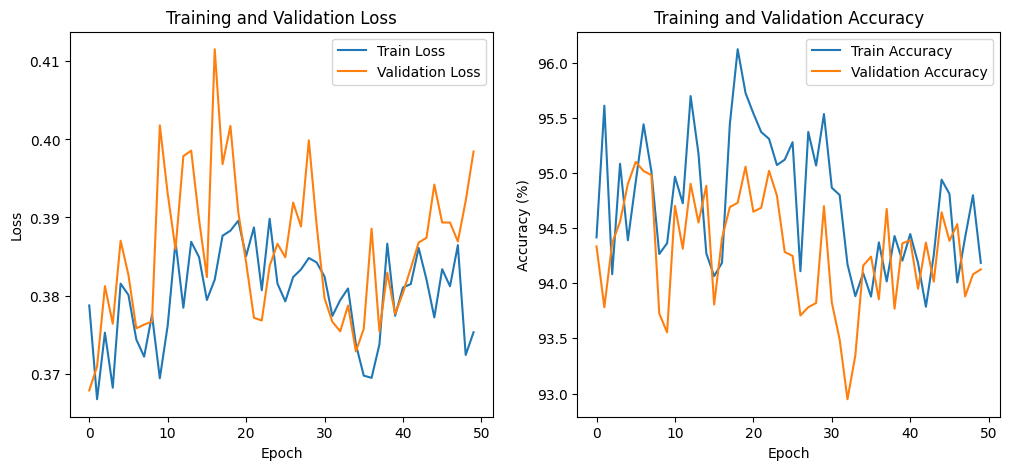

In [22]:
plot_training_results(res_2)

## Postprocessing

Créer une fonction prenant les prédictions du modèle (au niveau token) et sort les prédictions au niveau mot.<br>
Par exemple, admettons que, pour un mot, la prédiction du 1er token est la seule qu'on considère.<br>
si la phrase est "Bonjour John", avec les tokens \["bon", "jour", "Jo", "hn"\] avec les predictions \[0.12, 0.65, 0.88, 0.45\]<br>
Je veux récupérer les prédictions "bonjour": 0.12, "John": 0.88

In [96]:
def predict(model, token_ids):
    with torch.no_grad():
        probabilities = model(token_ids)[0]

    probabilities = probabilities[:, 1]

    print("probabilities sum: ", torch.sum(probabilities).cpu().numpy())

    return probabilities


In [97]:
model_2 = model_2.to("cpu")

In [142]:
def predictions_per_word(model, sentences, tokenizer):

    list_words = [sentence.split() for sentence in sentences]

    ts = [[token for word in list_word for token in tokenizer.tokenize(word)] for list_word in list_words]

    t_ids = [tokenizer.convert_tokens_to_ids(ids) for ids in ts]
    
    ts = [word for sentence in ts for word in sentence]

    max_len = max(len(ids) for ids in t_ids)
    t_ids = [ids + [0] * (max_len - len(ids)) for ids in t_ids]
    t_ids = torch.tensor(t_ids, dtype=torch.long)



    predictions = predict(model, t_ids)


    word_predictions = {}
    current_word = ""
    current_prediction = None

    for t, prediction in zip(ts, predictions):
        if t.startswith("▁"):
            if current_word:
                word_predictions[current_word] = current_prediction
            
            current_word = t[1:]
            current_prediction = float(prediction)
        else:
            current_word += t

    if current_word:
        word_predictions[current_word] = current_prediction

    return word_predictions

In [145]:
word_prediction = predictions_per_word(model_2, ["Jean Dupont est un homme très gentil.", "Je suis un homme très gentil."], tokenizer)
print(word_prediction)

probabilities sum:  0.99999994
{'Jean': 1.3501967772999723e-11, 'Dupont': 0.33331796526908875, 'est': 4.4067651288060006e-06, 'un': 0.33331796526908875, 'homme': 2.4805118300719187e-05, 'très': 1.0115194299942232e-06, 'gentil.': 0.33331796526908875}
